In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [45]:
def sum_cov(cov_str):
    cov_ints = cov_str.split('/')
    total_cov = 0
    for cov in cov_ints:
        total_cov += int(cov)
    return total_cov

def subset_gd_to_df(gdfile, cov=False):
    '''
    Returns dataframe created from annotated.gd. All rows are preserved,
    but only selected variables, namely entry type, entry id, 
    evidence id, genome id, position, mutation detail, frequency, gene product, 
    reject reasons, prediction mode, and polymorphism frequencies. 
    
    If cov=True, will also report total coverage (i.e., total_cov), 
    RA coverage (new_cov), JC coverage (new_junction_read_count), 
    and MC-flanking coverage (left_outside_cov + right_outside_cov).
    '''
    df = pd.read_table(gdfile, comment='#', names=range(200), dtype=str)
    df = df.dropna(axis=1, how='all')
    num_columns = len(df.columns)
    # https://stackoverflow.com/questions/27700591/reading-csv-files-with-messy-structure-with-pandas
    df.rename(columns = {0: 'entry_type', 1: 'entry_id', 2: 'evidence_id', 
                         3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    for row in df.index:
        #check each column
        col_index = 6
        while col_index < num_columns:
            #1. mutation frequencies
            if re.match('frequency=', str(df.loc[row, col_index])):
                df.loc[row, 'frequency'] = re.sub('frequency=', '', str(df.loc[row, col_index]))
                if df.loc[row, 'frequency'] == 'NA':
                    df.loc[row, 'frequency'] = np.nan
            #2. gene products
            elif re.match('gene_product=', str(df.loc[row, col_index])):
                df.loc[row, 'gene_product'] = re.sub('gene_product=', '', str(df.loc[row, col_index]))
            #3. polymorphism rejection reasons
            elif re.match('reject=', str(df.loc[row, col_index])):
                df.loc[row, 'reject'] = re.sub('reject=', '', str(df.loc[row, col_index]))
            #4. prediction type
            elif re.match('prediction=', str(df.loc[row, col_index])):
                df.loc[row, 'prediction'] = re.sub('prediction=', '', str(df.loc[row, col_index]))
            #5. polymorphism mode frequencies
            elif re.match('polymorphism_frequency=', str(df.loc[row, col_index])):
                df.loc[row, 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df.loc[row, col_index]))
                if df.loc[row, 'polymorphism_frequency'] == 'NA':
                    df.loc[row, 'polymorphism_frequency'] = np.nan
            
            if cov == True:
                if re.match('total_cov=', str(df.loc[row, col_index])):
                    total_cov = re.sub('total_cov=', '', str(df.loc[row, col_index]))
                    df.loc[row, 'total_cov'] = sum_cov(total_cov)
                elif re.match('new_cov=', str(df.loc[row, col_index])):
                    ra_cov = re.sub('new_cov=', '', str(df.loc[row, col_index]))
                    df.loc[row, 'ra_cov'] = sum_cov(ra_cov)
                elif re.match('new_junction_read_count=', str(df.loc[row, col_index])):
                    df.loc[row, 'jc_cov'] = re.sub('new_junction_read_count=', '', str(df.loc[row, col_index]))
                elif re.match('left_outside_cov=', str(df.loc[row, col_index])):
                    left_cov = re.sub('left_outside_cov=', '', str(df.loc[row, col_index]))
                    if left_cov == 'NA':
                        left_cov = 0
                    else:
                        df.loc[row, 'left_cov'] = int(left_cov)
                elif re.match('right_outside_cov', str(df.loc[row, col_index])):
                    right_cov = re.sub('right_outside_cov=', '', str(df.loc[row, col_index]))
                    if right_cov == 'NA':
                        right_cov = 0
                    else:
                        df.loc[row, 'right_cov'] = int(right_cov)
            col_index += 1
        #set reject col to 'NA' when no reject reason given.
        if 'reject' in df.columns:
            if (df.loc[row, 'reject'] == '') & (df.loc[row, 'evidence_id'] == '.'):
                df.loc[row, 'reject'] = np.nan
        else:
            df['reject'] = np.nan
    #set frequencies type to float 
    df[['frequency', 'polymorphism_frequency']] = df[['frequency', 'polymorphism_frequency']].astype(float)
    if cov == True:
        df[['left_cov', 'right_cov']].fillna(0)
        df['mc_cov'] = df.left_cov + df.right_cov
        return df[['entry_type', 'entry_id', 'evidence_id', 'genome_id', 'position', 'mutation_detail', 
                   'frequency', 'gene_product', 'reject', 'prediction', 'polymorphism_frequency', 
                   'total_cov', 'ra_cov', 'jc_cov', 'mc_cov']].copy()
    else:
        return df[['entry_type', 'entry_id', 'evidence_id', 'genome_id', 'position', 'mutation_detail', 
                    'frequency', 'gene_product', 'reject', 'prediction', 'polymorphism_frequency']].copy()

def select_mutation_rows(df):
    '''
    Selects mutation entry rows from dataframe. 
    '''
    df_mutations = df[(df['entry_type'] == 'INS') | 
                      (df['entry_type'] == 'DEL') | 
                      (df['entry_type'] == 'SNP') | 
                      (df['entry_type'] == 'SUB') | 
                      (df['entry_type'] == 'MOB') | 
                      (df['entry_type'] == 'AMP') | 
                      (df['entry_type'] == 'CON') | 
                      (df['entry_type'] == 'INV')]
    return df_mutations

def add_evidence_to_mutation_rows(df):
    '''
    Adds new column for evidence. 
    Evidence type taken from evidence entry rows, added to mutation entry rows.
    '''
    df_mutations = select_mutation_rows(df)
    df['evidence'] = ''
    for evidence in df_mutations['evidence_id']:
        multi_evidence = evidence.split(',')
        count = 0
        while count < len(multi_evidence):
            entry_row_index = df_mutations[df_mutations['evidence_id'] == evidence].index[0]
            evidence_row_index = df[df['entry_id'] == multi_evidence[count]].index[0]
            df.loc[entry_row_index, 'prediction'] = df.loc[evidence_row_index, 'prediction']
            df.loc[entry_row_index, 'polymorphism_frequency'] = df.loc[evidence_row_index, 'polymorphism_frequency']
            df.loc[entry_row_index, 'evidence'] = df.loc[entry_row_index, 'evidence'] + df.loc[evidence_row_index, 'entry_type']
            count += 1
    return df

def get_mutations_df(gdfile, culture_name, generation=np.nan):
    '''
    Adds new columns for culture name, and sampled generation.
    Returns df of only mutation entry rows, with added evidence column.
    '''
    gd_subset = subset_gd_to_df(gdfile)
    gd_subset_df = add_evidence_to_mutation_rows(gd_subset)
    gd_subset_df.insert(0, 'culture', culture_name)
    gd_subset_df.insert(1, 'generation', generation)
    mutations_df = select_mutation_rows(gd_subset_df).copy()
    return mutations_df

def get_population_subset_frequencies_to_plot(population_df, subset_df):
    '''
    Merge two mutation dfs to plot frequencies of mutations in common.
    '''
    merged = pd.merge(population_df, subset_df, on=('genome_id', 'position'))
    population_frequencies_df = merged.drop(['culture_y', 'generation_y', 'entry_type_y', 'entry_id_y', 'evidence_id_y', 
                                          'mutation_detail_y', 'frequency_y', 'gene_product_y', 'reject_y', 
                                          'prediction_y', 'polymorphism_frequency_y'], axis=1)
    reshaped = population_frequencies_df.pivot_table(index=['genome_id', 'position', 'entry_type_x', 'mutation_detail_x'], 
                                                     columns='generation_x', 
                                                     values='polymorphism_frequency_x').fillna(0).T
    return reshaped


In [4]:
# Complete UA3 dataframe
anc_complete = subset_gd_to_df('/Users/ymseah/Documents/sic_Ancestor_breseq/annotated.gd', cov=True)
ua3_100_complete = subset_gd_to_df('/Users/ymseah/Documents/sic_UA3-15_breseq/annotated.gd', cov=True)
ua3_300_complete = subset_gd_to_df('/Users/ymseah/Documents/sic_UA3.45_breseq/annotated.gd', cov=True)
ua3_500_complete = subset_gd_to_df('/Users/ymseah/Documents/sic_UA3-76_breseq/annotated.gd', cov=True)
ua3_780_complete = subset_gd_to_df('/Users/ymseah/Documents/sic_UA3.118_breseq/annotated.gd', cov=True)
ua3_1000_complete = subset_gd_to_df('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/evidence/annotated.gd', cov=True)
ua3_complete = pd.concat([anc_complete, ua3_100_complete, ua3_300_complete, ua3_500_complete, ua3_780_complete, 
                         ua3_1000_complete], ignore_index=True)

In [8]:
ra_freq_cov = ua3_complete[ua3_complete['entry_type'] == 'RA'].dropna(axis=1, how='all')
jc_freq_cov = ua3_complete[ua3_complete['entry_type'] == 'JC'].dropna(axis=1, how='all')

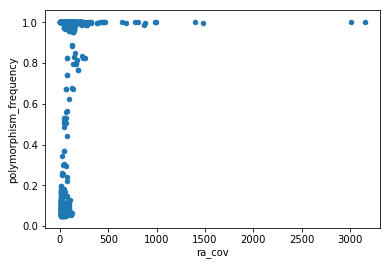

In [52]:
%matplotlib inline
ra_freq_cov['reject'] = ra_freq_cov['reject'].fillna(0)
ra_freq_cov[ra_freq_cov['reject'] == 0].plot(x = 'ra_cov', y = 'polymorphism_frequency', kind='scatter', legend=False)

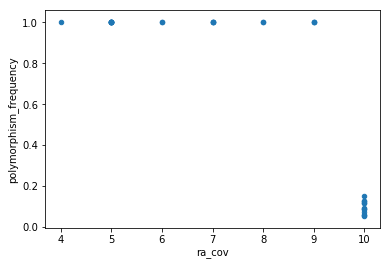

In [58]:
ra_freq_cov[(ra_freq_cov['reject'] == 0) & (ra_freq_cov['ra_cov'] <= 10)].plot(x = 'ra_cov', y = 'polymorphism_frequency', kind='scatter', legend=False)

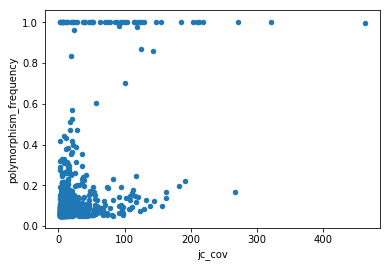

In [54]:
jc_freq_cov['reject'] = jc_freq_cov['reject'].fillna(0)
jc_freq_cov['jc_cov'] = jc_freq_cov['jc_cov'].astype(int)
jc_freq_cov[jc_freq_cov['reject'] == 0].plot(x = 'jc_cov', y = 'polymorphism_frequency', kind='scatter', legend=False)

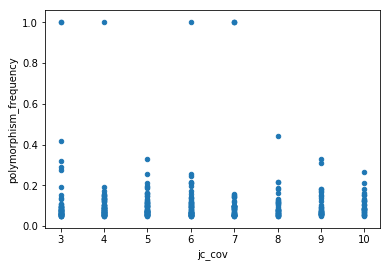

In [57]:
jc_freq_cov[(jc_freq_cov['reject'] == 0) & (jc_freq_cov['jc_cov'] <= 10)].plot(x = 'jc_cov', y = 'polymorphism_frequency', kind='scatter', legend=False)